In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly.express as px

from plotly import graph_objects as go

import sys
sys.path.append("..")

flatten = lambda t: [item for sublist in t for item in sublist]

In [2]:
comment_df = pd.read_excel("..\data\cleaned_swed_lemma.xlsx")
comment_df.drop(index = [9, 1555, 2474, 2483, 4346, 7212], inplace = True)

# TF-IDF

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer()

In [4]:
term_doc = pd.DataFrame(c.fit_transform(comment_df.text.astype('U')).toarray())
#term_doc = pd.get_dummies(comment_df.text)

term_frequency = term_doc.divide( term_doc.sum(axis="columns"), axis="rows")
term_frequency.sum(axis="columns")

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8584    1.0
8585    1.0
8586    1.0
8587    1.0
8588    1.0
Length: 8589, dtype: float64

In [5]:
# idf number of documents / number of documents containing the word
temp = np.zeros(len(term_doc.columns))

for i in range(len(temp)):
    temp[i] = sum(term_doc.iloc[:,i].map(lambda x: 1 if x > 0 else 0))
    
idf = np.log(len(term_doc) / temp)

In [6]:
tf_idf = term_frequency * idf


In [7]:
#LSA method: making SVD with the tf_idf, then taking the first n most significant vectors to score the documents

from sklearn.decomposition import TruncatedSVD
n_comp = 7
svd = TruncatedSVD(n_components = n_comp)
lsa = svd.fit_transform(tf_idf)

In [8]:
topic_encoded_df = pd.DataFrame(lsa, index = comment_df.index,
                                columns = [f"topic{i}" for i in range(n_comp)])
topic_encoded_df["text"] = comment_df.text

In [9]:
encoding_matrix = pd.DataFrame(svd.components_, 
                               index = [f"topic{i}" for i in range(n_comp)], 
                               columns = c.get_feature_names())


C:\Users\balin\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
top_by_topic = pd.DataFrame()
for col in encoding_matrix.index:
    topic_temp_df = pd.DataFrame(encoding_matrix.T.sort_values(col, axis = "rows", ascending = False, 
                                                               key = np.abs)[col][:15]).reset_index()
    topic_temp_df.columns = [col, col+"_value"]
    top_by_topic = pd.concat([top_by_topic, topic_temp_df.round(2)], axis = 1)

In [11]:
top_by_topic.to_excel(r"..\data\top_by_topic_LSI_lemma.xlsx")
top_by_topic

,topic0,topic0_value,topic1,topic1_value,topic2,topic2_value,topic3,topic3_value,topic4,topic4_value,topic5,topic5_value,topic6,topic6_value
0,mzp,0.24,átlépted,0.30,gyurcsány,0.60,poll,0.73,dobrev,0.49,szavaz,0.60,dobrev,-0.40
1,szavaz,0.23,korlátot,0.30,stop,0.41,peter,0.56,mzp,0.33,online,0.26,tóth,0.39
2,tud,0.21,végrehajt,0.29,karácsony,0.31,tamad,0.15,gyurcsány,-0.32,stop,0.21,csaba,0.38
3,dobrev,0.21,poszt,0.29,szavaz,-0.23,cimbe,0.15,stop,-0.23,csaba,-0.16,karácsony,0.31
4,fog,0.20,napi,0.29,online,-0.12,tegyel,0.14,karácsony,0.20,tóth,-0.16,gyurcsány,-0.22
5,karácsony,0.19,próbál,0.27,mzp,0.11,ujra,0.13,tud,-0.17,fog,0.15,mzp,0.19
6,fidesz,0.18,intézkedés,0.27,tud,-0.11,reportol,0.12,klára,0.16,tud,-0.15,fog,0.18
7,gyurcsány,0.16,automatikus,0.26,dobrev,0.11,vegzetes,0.08,nyer,0.16,orbán,-0.14,klára,-0.17
8,mond,0.14,töröltük,0.26,átlépted,0.10,lecsap,0.08,ember,-0.15,dobrevre,0.13,orbán,-0.16
9,nyer,0.14,posztodat,0.26,korlátot,0.10,figyelmes,0.08,fog,0.11,mzp,-0.12,stop,0.14


In [12]:
#health check: check which elements are none
comment_df.reset_index().drop(columns = ["index"])[term_frequency.isna().T.any()].index

Int64Index([], dtype='int64')

(1.0, 60.0)

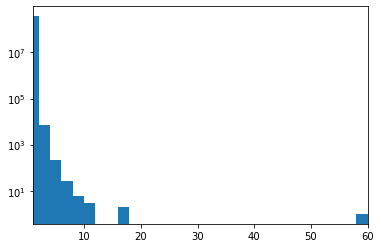

In [13]:
#health check
plt.hist(c.fit_transform(comment_df.text).toarray().flatten(), bins = 30)
plt.yscale("log")
plt.xlim(1,60)